<a href="https://colab.research.google.com/github/mandliya/textvqa/blob/master/see_east.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 8 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,732 kB/s)
Selecting previously unselecte

In [67]:
!pip install -U pillow

     |████████████████████████████████| 2.0MB 2.7MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0


In [0]:
!pip install pytesseract 

     |████████████████████████████████| 174kB 4.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/d5/90/56/ab7b652592da86821293f7cadc1c554aa376a0d57ce414d0a0
Successfully built pytesseract


In [6]:
%cd /content
!mkdir /content/text-ocr
%cd /content/text-ocr

/content
/content/text-ocr


In [21]:
!ls

frozen_east_text_detection.pb


In [7]:
!git clone https://github.com/oyyd/frozen_east_text_detection.pb

Cloning into 'frozen_east_text_detection.pb'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3
Unpacking objects: 100% (3/3), done.


In [22]:
!wget -O /content/text-ocr/text_recog.zip https://bartzi.de/documents/attachment/download?hash_value=0b3329827cb485324329065ba8edf37e_15

--2019-06-11 05:56:00--  https://bartzi.de/documents/attachment/download?hash_value=0b3329827cb485324329065ba8edf37e_15
Resolving bartzi.de (bartzi.de)... 178.254.28.15
Connecting to bartzi.de (bartzi.de)|178.254.28.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10660987 (10M) [application/zip]
Saving to: ‘/content/text-ocr/text_recog.zip’

/content/text-ocr/t 100%[===================>]  10.17M  1.16MB/s    in 10s     

2019-06-11 05:56:11 (1.01 MB/s) - ‘/content/text-ocr/text_recog.zip’ saved [10660987/10660987]



In [0]:
#!unzip text_recog.zip -d text_recog

In [25]:
%cd /content/text-ocr
!git clone https://github.com/Bartzi/see

/content/text-ocr
Cloning into 'see'...
remote: Enumerating objects: 289, done.
remote: Total 289 (delta 0), reused 0 (delta 0), pack-reused 289
Receiving objects: 100% (289/289), 532.48 KiB | 10.24 MiB/s, done.
Resolving deltas: 100% (139/139), done.


In [26]:
!ls

frozen_east_text_detection.pb  see  text_recog	text_recog.zip


In [0]:
import sys
sys.path.append('/content/text-ocr/see')
sys.path.append('/content/text-ocr/see/chainer')

In [0]:
from imutils.object_detection import non_max_suppression
import numpy as np
import cv2

import importlib
import os
import json
from collections import OrderedDict
from pprint import pprint

import chainer
import chainer.functions as F
from chainer import configuration

from PIL import Image
from IPython.display import display, HTML, clear_output
from ipywidgets import widgets, Layout
from io import BytesIO
import requests

from utils.datatypes import Size
from google.colab.patches import cv2_imshow
import cv2
import urllib.request
import numpy as np


See related code



In [0]:
def get_class_and_module(log_data):
    if not isinstance(log_data, list):
        if 'InverseCompositional' in log_data:
            module_name = 'ic_stn.py'
            klass_name = log_data
        else:
            module_name = 'text_recognition.py'
            klass_name = log_data
    else:
        klass_name, module_name = log_data
    return klass_name, module_name


def load_module(module_file):
    module_spec = importlib.util.spec_from_file_location("models.model", module_file)
    module = importlib.util.module_from_spec(module_spec)
    module_spec.loader.exec_module(module)
    return module


def build_recognition_net(recognition_net_class, args):
    return recognition_net_class(
        args['target_shape'],
        num_rois=args['timesteps'],
        label_size=52,
    )


def build_localization_net(localization_net_class, args):
    return localization_net_class(
        args['dropout_ratio'],
        args['timesteps'],
        0,
        args['target_shape'],
        zoom=1.0,
        do_parameter_refinement=False)


def build_fusion_net(fusion_net_class, localization_net, recognition_net):
    return fusion_net_class(localization_net, recognition_net)


def create_network(args, log_data):
    # Step 1: build network
    localization_net_class_name, localization_module_name = get_class_and_module(log_data['localization_net'])
    module = load_module(os.path.abspath(os.path.join(args['model_dir'], localization_module_name)))
    localization_net_class = eval('module.{}'.format(localization_net_class_name))
    localization_net = build_localization_net(localization_net_class, args)

    recognition_net_class_name, recognition_module_name = get_class_and_module(log_data['recognition_net'])
    module = load_module(os.path.abspath(os.path.join(args['model_dir'], recognition_module_name)))
    recognition_net_class = eval('module.{}'.format(recognition_net_class_name))
    recognition_net = build_recognition_net(recognition_net_class, args)

    fusion_net_class_name, fusion_module_name = get_class_and_module(log_data['fusion_net'])
    module = load_module(os.path.abspath(os.path.join(args['model_dir'], fusion_module_name)))
    fusion_net_class = eval('module.{}'.format(fusion_net_class_name))
    net = build_fusion_net(fusion_net_class, localization_net, recognition_net)

#     if args['gpu'] >= 0:
#         net.to_gpu(args['gpu'])

    return net

def load_image(image_file, xp, image_size):
    with Image.open(image_file) as the_image:
        the_image = the_image.convert('L')
        the_image = the_image.resize((image_size.width, image_size.height), Image.LANCZOS)
        display(the_image)
        image = xp.asarray(the_image, dtype=np.float32)
        image /= 255
        image = xp.broadcast_to(image, (3, image_size.height, image_size.width))
        return image
  

def strip_prediction(predictions, xp, blank_symbol):
    words = []
    for prediction in predictions:
        blank_symbol_seen = False
        stripped_prediction = xp.full((1,), prediction[0], dtype=xp.int32)
        for char in prediction:
            if char == blank_symbol:
                blank_symbol_seen = True
                continue
            if char == stripped_prediction[-1] and not blank_symbol_seen:
                continue
            blank_symbol_seen = False
            stripped_prediction = xp.hstack((stripped_prediction, char.reshape(1, )))
        words.append(stripped_prediction)
    return words


def extract_bbox(bbox, image_size, target_shape, xp):
    bbox.data[...] = (bbox.data[...] + 1) / 2
    bbox.data[0, :] *= image_size.width
    bbox.data[1, :] *= image_size.height

    x = xp.clip(bbox.data[0, :].reshape(target_shape), 0, image_size.width)
    y = xp.clip(bbox.data[1, :].reshape(target_shape), 0, image_size.height)

    top_left = (float(x[0, 0]), float(y[0, 0]))
    bottom_right = (float(x[-1, -1]), float(y[-1, -1]))

    return top_left, bottom_right


In [0]:
def predict_text(image, startY, endY, startX, endX):
  args = {}
  args['model_dir'] = '/content/text-ocr/text_recog/model'
  args['char_map'] = '/content/text-ocr/see/datasets/textrec/ctc_char_map.json'
  args['log_name'] = 'log'
  args['dropout_ratio']= 0.5
  args['blank_symbol'] = 0
  # max number of text regions in the image
  args['timesteps'] = 23
  # max number of characters per word
  args['num_labels'] = 20
  args['gpu'] = 0
  args['snapshot_name'] = 'model_190000.npz'
  #args['image_path'] = image_path


  # open log and extract meta information
  with open(os.path.join(args['model_dir'], args['log_name'])) as the_log:
    log_data = json.load(the_log)[0]

  #print(log_data['image_size'])
  target_shape = Size._make(log_data['target_size'])
  image_size = Size._make(log_data['image_size'])

  args['target_shape'] = log_data['target_size']
  xp =  np

  network = create_network(args, log_data)

  # load weights
  with np.load(os.path.join(args['model_dir'], args['snapshot_name'])) as f:
      chainer.serializers.NpzDeserializer(f).load(network)

  # load char map
  with open(args['char_map']) as the_map:
    char_map = json.load(the_map)

  #load image
  #image = load_image(args['image_path'], xp, image_size)
  image = image[startY:endY, startX:endX]
  image = Image.fromarray(image)
  image = image.convert('L')
  image = image.resize((image_size.width, image_size.height), Image.LANCZOS)
  #display(the_image)
  image = xp.asarray(image, dtype=np.float32)
  image /= 255
  image = np.broadcast_to(image, (3, image_size.height, image_size.width))

  with configuration.using_config('train', False):
      predictions, crops, grids = network(image[xp.newaxis, ...])

  # extract class scores for each word
  words = OrderedDict({})

  predictions = F.concat([F.expand_dims(prediction, axis=0) for prediction in predictions], axis=0)

  classification = F.softmax(predictions, axis=2)
  classification = classification.data
  classification = xp.argmax(classification, axis=2)
  classification = xp.transpose(classification, (1, 0))

  word = strip_prediction(classification, xp, args['blank_symbol'])[0]
  word = "".join(map(lambda x: chr(char_map[str(x)]), word))
  print("Word: ", word)

  bboxes = []
  for bbox in grids[0]:
      bbox = extract_bbox(bbox, image_size, target_shape, xp)
      bboxes.append(OrderedDict({
          'top_left': bbox[0],
          'bottom_right': bbox[1]
      }))
  words[word] = bboxes

  return word

In [0]:
def decode_predictions(scores, geometry, args):
	# grab the number of rows and columns from the scores volume, then
	# initialize our set of bounding box rectangles and corresponding
	# confidence scores
	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []

	# loop over the number of rows
	for y in range(0, numRows):
		# extract the scores (probabilities), followed by the
		# geometrical data used to derive potential bounding box
		# coordinates that surround text
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]

		# loop over the number of columns
		for x in range(0, numCols):
			# if our score does not have sufficient probability,
			# ignore it
			if scoresData[x] < args["min_confidence"]:
				continue

			# compute the offset factor as our resulting feature
			# maps will be 4x smaller than the input image
			(offsetX, offsetY) = (x * 4.0, y * 4.0)

			# extract the rotation angle for the prediction and
			# then compute the sin and cosine
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# use the geometry volume to derive the width and height
			# of the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]

			# compute both the starting and ending (x, y)-coordinates
			# for the text prediction bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)

			# add the bounding box coordinates and probability score
			# to our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])

	# return a tuple of the bounding boxes and associated confidences
	return (rects, confidences)

In [0]:


def predict(image_path, detector_model_path, image_width, image_height):
  args = {}
  args['image'] = image_path
  args['east'] = detector_model_path
  args['min_confidence'] = 0.3
  args['width'] = image_width
  args['height'] = image_height
  args['padding'] = 0.0
  
  req = urllib.request.urlopen(image_path)
  arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
  image = cv2.imdecode(arr, -1) # 'Load it as it is'
  orig = image.copy()
  (origH, origW) = image.shape[:2]

  
  #set the new width and height and then determine the ratio in change
  #for both the width and height
  (newW, newH) = (args["width"], args["height"])
  rW = origW / float(newW)
  rH = origH / float(newH)
  
  #resize the image and grab the new image dimensions
  image = cv2.resize(image, (newW, newH))
  (H, W) = image.shape[:2]
  
  layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]
 
  # load the pre-trained EAST text detector
  print("[INFO] loading EAST text detector...")
  net = cv2.dnn.readNet(args["east"])
  
  blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)
  net.setInput(blob)
  (scores, geometry) = net.forward(layerNames)
 
  # decode the predictions, then  apply non-maxima suppression to
  # suppress weak, overlapping bounding boxes
  (rects, confidences) = decode_predictions(scores, geometry, args)
  boxes = non_max_suppression(np.array(rects), probs=confidences)
  
  print("Found ", len(boxes), " boxes.")
  # initialize the list of results
  results = []

  # loop over the bounding boxes
  for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)

    # in order to obtain a better OCR of the text we can potentially
    # apply a bit of padding surrounding the bounding box -- here we
    # are computing the deltas in both the x and y directions
    dX = int((endX - startX) * args["padding"])
    dY = int((endY - startY) * args["padding"])

    # apply padding to each side of the bounding box, respectively
    startX = max(0, startX - dX)
    startY = max(0, startY - dY)
    endX = min(origW, endX + (dX * 2))
    endY = min(origH, endY + (dY * 2))

    # extract the actual padded ROI
    roi = orig[startY:endY, startX:endX]
    
    # in order to apply Tesseract v4 to OCR text we must supply
    # (1) a language, (2) an OEM flag of 4, indicating that the we
    # wish to use the LSTM neural net model for OCR, and finally
    # (3) an OEM value, in this case, 7 which implies that we are
    # treating the ROI as a single line of text
    #config = ("-l eng --oem 1 --psm 7")
    #text = pytesseract.image_to_string(roi, config=config)
    text = predict_text(orig, startY, endY, startX, endX)
   
    print("Text from SEE:", text)
  
    # add the bounding box coordinates and OCR'd text to the list
    # of results
    results.append(((startX, startY, endX, endY), text))
    
    

    # sort the results bounding box coordinates from top to bottom
    results = sorted(results, key=lambda r:r[0][1])

    # loop over the results
    for ((startX, startY, endX, endY), text) in results:
      # display the text OCR'd by Tesseract
      print("OCR TEXT")
      print("========")
      #print("{}\n".format(text))

      # strip out non-ASCII text so we can draw the text on the image
      # using OpenCV, then draw the text and a bounding box surrounding
      # the text region of the input image
      text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
      output = orig.copy()
      cv2.rectangle(output, (startX, startY), (endX, endY),
        (0, 0, 255), 2)
      cv2.putText(output, text, (startX, startY - 20),
        cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)

      # show the output image
      cv2_imshow(output)

Text(value='https://akm-img-a-in.tosshub.com/indiatoday/images/story/201606/kohli_fbsport_647_060216040158.jpg…

Button(description='Ask Image!', style=ButtonStyle())

[INFO] loading EAST text detector...
Found  1  boxes.
Word:  sahar
Text from SEE: sahar
OCR TEXT


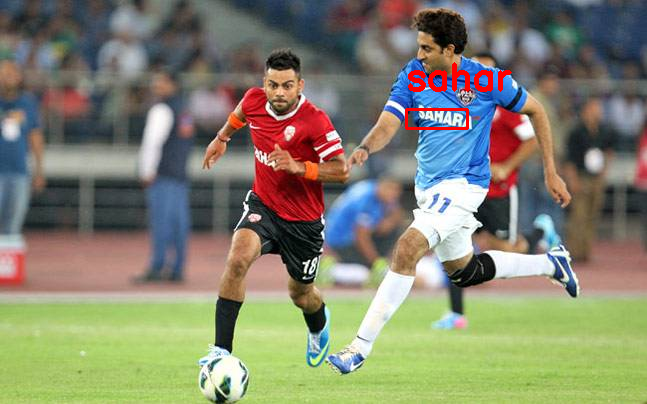

In [0]:
def get_actual_image(image_path):
    if image_path.startswith('http'):
        path = requests.get(image_path, stream=True).raw
    else:
        path = image_path
    return path

def init_widgets(url):
  image_text = widgets.Text(
    description="Image URL", layout=Layout(minwidth="70%")
  )
  
  image_text.value = url
  submit_button = widgets.Button(description="Ask Image!")

  display(image_text)
  display(submit_button)

  submit_button.on_click(lambda b: on_button_click(
      b, image_text
  ))
  
  return image_text
  
def on_button_click(b, image_text):
  clear_output()
  #image_path = get_actual_image(image_text.value)
  #image_path = get_actual_image(image_text.value)
  image_path = image_text.value
  init_widgets(image_text.value)
  #display(image)
  detector_model_path = '/content/text-ocr/frozen_east_text_detection.pb/frozen_east_text_detection.pb'
  image_width = 320
  image_height = 320
  predict(image_path, detector_model_path, image_width, image_height)
  #predict(image_path)

image_text= init_widgets(
    "http://d21gd0ap5v1ndt.cloudfront.net/web04/ucmerced/images/2018-19/wsoc_finalee.jpg", 
)

In [0]:
!wget -O /content/sample_data/ocr.jpg https://www.pyimagesearch.com/wp-content/uploads/2018/09/opencv_ocr_result02.jpg

--2019-06-09 05:24:48--  https://www.pyimagesearch.com/wp-content/uploads/2018/09/opencv_ocr_result02.jpg
Resolving www.pyimagesearch.com (www.pyimagesearch.com)... 50.116.58.97
Connecting to www.pyimagesearch.com (www.pyimagesearch.com)|50.116.58.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94316 (92K) [image/jpeg]
Saving to: ‘/content/sample_data/ocr.jpg’

/content/sample_dat 100%[===================>]  92.11K  --.-KB/s    in 0.04s   

2019-06-09 05:24:48 (2.29 MB/s) - ‘/content/sample_data/ocr.jpg’ saved [94316/94316]

